In [1]:
import pandas as pd
import librosa
import os
import numpy as np 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

In [2]:
from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2
import tensorflow as tf

## Arquivo de metadados

In [3]:
#audio_path = 'spectogram/'
#spectograms = os.listdir(audio_path)

#metadata with most_freq chords indicator
df = pd.read_csv('metadata.csv', sep = ',')
df_chords = df


## PCP

In [4]:
X = np.load("X_PCP_SOLO.npy")
y = np.load("y_PCP_SOLO.npy")

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
X_train.shape

(2894, 12, 1216)

In [6]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [7]:
import pickle 

with open('chords_mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [10]:
X_test.shape

(1426, 12, 1216)

## Custom Model

In [20]:
import mlflow

mlflow.tensorflow.autolog(every_n_iter = 2)

2023/11/08 21:19:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


In [10]:
X_train.reshape(755,1216,12).shape

(755, 1216, 12)

In [7]:
# How data should be structured
num_rows = round(1216/4)
num_columns = 12*4 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [8]:
def create_model():

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model


model = create_model()

In [9]:
model.compile(
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()],  
    optimizer='adam')

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 302, 46, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 302, 46, 32)       0         
                                                                 
 batch_normalization (Batch  (None, 302, 46, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 44, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 300, 44, 32)       0         
                                                                 
 batch_normalization_1 (Bat  (None, 300, 44, 32)       128       
 chNormalization)                                       

In [11]:
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=50, 
                    epochs=50, 
                    validation_data=(X_test,y_test_encoded),
                    verbose=1)

Epoch 1/50
29/29 [==============================] - 56s 2s/step - loss: 2.9668 - categorical_accuracy: 0.1424 - val_loss: 3.2443 - val_categorical_accuracy: 0.0940
Epoch 2/50
29/29 [==============================] - 56s 2s/step - loss: 2.9244 - categorical_accuracy: 0.1596 - val_loss: 3.0594 - val_categorical_accuracy: 0.1192
Epoch 3/50
29/29 [==============================] - 57s 2s/step - loss: 2.8883 - categorical_accuracy: 0.1596 - val_loss: 3.5743 - val_categorical_accuracy: 0.0842
Epoch 4/50
29/29 [==============================] - 58s 2s/step - loss: 2.8771 - categorical_accuracy: 0.1638 - val_loss: 3.8791 - val_categorical_accuracy: 0.0870
Epoch 5/50
29/29 [==============================] - 59s 2s/step - loss: 2.8626 - categorical_accuracy: 0.1700 - val_loss: 3.9840 - val_categorical_accuracy: 0.0715
Epoch 6/50
29/29 [==============================] - 61s 2s/step - loss: 2.8448 - categorical_accuracy: 0.1721 - val_loss: 4.3443 - val_categorical_accuracy: 0.0827
Epoch 7/50
29/29

## Feed Forward Network

In [11]:
# usar rede convolucional PCP
X_train_ffn = X_train.reshape(2894,1216,12)
X_test_ffn =  X_test.reshape(1426,1216,12)

In [12]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_train_encoded = le.fit_transform(y_train)

#mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [14]:


def sigmoid(hidden_layer):
    model_relu = tf.keras.models.Sequential([ 
        tf.keras.layers.Flatten(input_shape=(1216,12)), 
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Dense(42,activation='softmax')
  ]) 

#Compiling using loss function, Optimizer and Metrics
    model_relu.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model_relu






#Feeding the model and Evalutating the Accuracy
def model_fitting(model_fit):
    checkpoint_path = "dashboard/model_checkpoint/model.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    #teste como validacao pra ver o momento que erro começou a subir
    model_fit.fit(X_train_ffn, y_train_encoded, epochs=60, validation_data=(X_test_ffn,y_test_encoded), callbacks = [cp_callback])
    test_loss, test_accuracy = model_fit.evaluate(X_test_ffn,  y_test_encoded, verbose=2)
    print('\nTest accuracy:', test_accuracy)
    return test_accuracy, test_loss

#Intializing the final array
err = np.zeros(4)
loss = np.zeros(4)

#ReLU with 128 hidden values
model = sigmoid(128)
err[0],loss[0] = model_fitting(model)

Epoch 1/60
91/91 [==============================] - ETA: 0s - loss: 3.0646 - accuracy: 0.2429
Epoch 1: saving model to dashboard/model_checkpoint\model.ckpt
91/91 [==============================] - 4s 40ms/step - loss: 3.0646 - accuracy: 0.2429 - val_loss: 2.4826 - val_accuracy: 0.3366
Epoch 2/60
91/91 [==============================] - ETA: 0s - loss: 1.9335 - accuracy: 0.4447
Epoch 2: saving model to dashboard/model_checkpoint\model.ckpt
91/91 [==============================] - 3s 37ms/step - loss: 1.9335 - accuracy: 0.4447 - val_loss: 2.4179 - val_accuracy: 0.3689
Epoch 3/60
91/91 [==============================] - ETA: 0s - loss: 1.6348 - accuracy: 0.5173
Epoch 3: saving model to dashboard/model_checkpoint\model.ckpt
91/91 [==============================] - 3s 37ms/step - loss: 1.6348 - accuracy: 0.5173 - val_loss: 2.2609 - val_accuracy: 0.4236
Epoch 4/60
91/91 [==============================] - ETA: 0s - loss: 1.6008 - accuracy: 0.5508
Epoch 4: saving model to dashboard/model_chec

In [11]:
checkpoint_path = "dashboard/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

ERROR:tensorflow:Couldn't match files for checkpoint dashboard\model.ckpt


In [14]:
# Create a new model instance
model = sigmoid(128)

# Load the previously saved weights
model.load_weights(latest)


In [10]:
test_loss, test_accuracy = model.evaluate(X_test_ffn,  y_test_encoded, verbose=2)

23/23 - 0s - loss: 1.5765 - accuracy: 0.7251 - 132ms/epoch - 6ms/step


In [28]:
X_test_ffn[0,:,:].reshape(1, 1216,12)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [31]:
df_chords

,Filename,Loc,Acorde,Arquivo Original,most_freq
0,file_1393.wav,processed_audio/,A#:min,01_SS2-88-F_comp_hex.wav,0
1,file_1394.wav,processed_audio/,D#:7,01_SS2-88-F_comp_hex.wav,0
2,file_1395.wav,processed_audio/,G#:maj,01_SS2-88-F_comp_hex.wav,1
3,file_1396.wav,processed_audio/,C#:maj,01_SS2-88-F_comp_hex.wav,1
4,file_1397.wav,processed_audio/,G:hdim7,01_SS2-88-F_comp_hex.wav,0
...,...,...,...,...,...
2155,file_180806.wav,processed_audio/,F:min,00_Funk3-112-C#_comp_hex.wav,0
2156,file_180807.wav,processed_audio/,F#:maj,00_Funk3-112-C#_comp_hex.wav,1
2157,file_180808.wav,processed_audio/,C#:maj,00_Funk3-112-C#_comp_hex.wav,1
2158,file_180809.wav,processed_audio/,F#:maj,00_Funk3-112-C#_comp_hex.wav,1


In [57]:
#model.predict(X_test_ffn)[1, :]
#X[0,:,:]

#predição correta

pred_aux = model.predict(X[0,:,:].reshape(1, 1216,12))

nn.get_chord(pred_aux)

#df_chords

1/1 [==============================] - 0s 26ms/step


'A#:maj'

In [87]:
import dashboard.preprocessing_pipeline as pp 

#chroma = pp.PCP('dashboard/audio_teste.wav')[:, :1216]
chroma2 =  pp.PCP('dashboard/chord_x.wav')[:, :1216]
#padding = pp.add_padding(chroma2)
# chroma = np.pad(chroma2, pad_width = ((0,0), (0,1216-chroma2.shape[1])))

# padded_chroma = pp.add_padding(tf.expand_dims(chroma, 0))
# expand_chroma = tf.expand_dims(padded_chroma[0], 1)
# reshaped_chroma = tf.reshape(expand_chroma, [1, 1216, 12])

(12, 2397)

In [88]:
# Given an numpy array of features, zero-pads each ocurrence to max_padding
def add_padding(features, max_padding=174):
    padded = []

    # Add padding
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < max_padding):
            xDiff = max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

padded  = add_padding([chroma2], max_padding= 1216)
reshaped_padded = padded[0].reshape(1,1216,12)


In [89]:
pred_pipeline = model.predict(reshaped_padded)

import dashboard.nn_amodel as nn 


nn.get_chord(pred_pipeline)

#reshaped_chroma.shape

1/1 [==============================] - 0s 25ms/step


'E:hdim7'

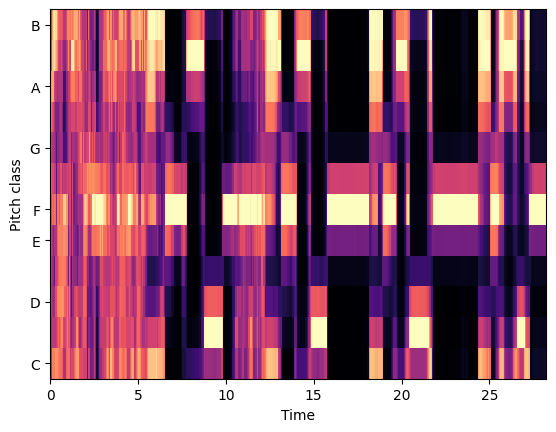

In [28]:
import librosa
librosa.display.specshow(chroma, y_axis='chroma', x_axis = 'time')


array([[0.37333637, 0.48328066, 0.48328066, ..., 0.07839249, 0.07940821,
        0.07940821],
       [0.42284214, 0.48739442, 0.4570775 , ..., 0.05244875, 0.05269052,
        0.05269052],
       [0.53522927, 0.54242903, 0.53522927, ..., 0.02593376, 0.02611391,
        0.02623735],
       ...,
       [0.6381211 , 0.6381211 , 0.6381211 , ..., 0.07635138, 0.07727032,
        0.07727032],
       [0.54326725, 0.54326725, 0.54326725, ..., 0.09062101, 0.09167526,
        0.09167526],
       [0.47837007, 0.47837007, 0.47837007, ..., 0.08819962, 0.08965237,
        0.08965237]], dtype=float32)

## Metrics

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

preds_score = model.predict(X_test)
pred_idx = tf.math.argmax(preds_score, axis = 1)
#y_test_idx = tf.math.argmax(y_test_encoded, axis = 1)
target_names = mapping.keys()

print('F1-Score: ', f1_score(y_test_encoded, pred_idx, average = 'macro'))
print('F1-Score: ', f1_score(y_test_encoded, pred_idx, average = 'macro'))

print(classification_report(y_test_encoded, pred_idx, target_names= target_names))


23/23 [==============================] - 0s 4ms/step
F1-Score:  0.6428898093241839
F1-Score:  0.6428898093241839
              precision    recall  f1-score   support

        A#:7       0.00      0.00      0.00         3
    A#:hdim7       0.33      0.67      0.44         3
      A#:maj       0.65      0.81      0.72        32
      A#:min       0.93      0.76      0.84        17
         A:7       0.67      1.00      0.80         4
     A:hdim7       1.00      0.33      0.50         3
       A:maj       0.73      0.87      0.79        31
       A:min       0.62      0.73      0.67        11
       B:maj       0.56      0.69      0.62        26
       B:min       0.56      0.36      0.43        14
        C#:7       0.12      0.11      0.12         9
    C#:hdim7       1.00      1.00      1.00         3
      C#:maj       0.88      0.82      0.85        45
      C#:min       0.80      0.80      0.80        15
         C:7       0.92      0.80      0.86        15
     C:hdim7       0.8

In [25]:
y_test_encoded.shape

(713,)

In [35]:
from sklearn.metrics import f1_score
import tensorflow as tf
#print('Acurácia: ', f1_score(y_test, preds))

<tf.Tensor: shape=(373,), dtype=int64, numpy=
array([4, 1, 2, 1, 0, 7, 1, 3, 6, 4, 6, 4, 6, 7, 5, 8, 5, 8, 3, 8, 5, 0,
       0, 7, 7, 1, 3, 3, 7, 2, 5, 7, 3, 2, 9, 5, 4, 4, 3, 4, 3, 9, 0, 6,
       5, 8, 9, 1, 3, 4, 7, 8, 8, 1, 5, 4, 7, 1, 7, 7, 4, 9, 9, 0, 9, 7,
       8, 9, 9, 3, 1, 1, 7, 9, 0, 7, 7, 1, 8, 2, 8, 9, 7, 5, 1, 0, 7, 5,
       1, 1, 5, 4, 2, 8, 0, 7, 9, 5, 1, 6, 9, 5, 8, 9, 4, 8, 2, 6, 9, 0,
       9, 2, 5, 4, 7, 7, 3, 6, 0, 9, 6, 5, 6, 3, 1, 5, 3, 1, 2, 4, 7, 5,
       9, 2, 8, 2, 4, 6, 2, 6, 9, 4, 3, 1, 4, 9, 1, 4, 8, 9, 5, 6, 6, 7,
       7, 1, 3, 7, 3, 8, 2, 7, 1, 6, 5, 9, 4, 2, 8, 6, 9, 2, 2, 6, 0, 5,
       2, 8, 0, 8, 8, 0, 5, 0, 7, 4, 7, 5, 1, 9, 2, 9, 7, 8, 0, 4, 7, 3,
       3, 7, 0, 9, 6, 2, 9, 3, 0, 9, 9, 6, 4, 1, 3, 2, 7, 4, 4, 9, 8, 6,
       1, 7, 1, 5, 0, 1, 8, 2, 2, 6, 7, 1, 7, 7, 6, 1, 2, 4, 1, 7, 3, 1,
       8, 4, 9, 4, 9, 7, 8, 5, 8, 4, 9, 2, 9, 2, 8, 7, 1, 4, 1, 4, 2, 1,
       0, 0, 1, 8, 2, 2, 6, 6, 4, 9, 7, 4, 7, 5, 3, 4, 5, 7, 9, 5, 5, 9,
     

In [24]:



def add_channels(array):

    arr = np.expand_dims(array, axis = -1)
    # pad the missing dims with zeros
    pad = ((0,0),)*3 + ((0,2),)
    padded = np.pad(arr, pad, 'constant', constant_values = 0)

    padded = padded.reshape(padded.shape[0], padded.shape[1]*4, round(padded.shape[2]/4), 3)
    

    return padded

X_train_mobile = add_channels(X_train)
X_test_mobile = add_channels(X_test)

IMG_SHAPE = (X_train_mobile.shape[1],X_train_mobile.shape[2] ,3)



base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE),
                                               include_top=False,
                                               weights='imagenet')
